In [1]:
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 1, 1
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 50

In [4]:
T_rend = kernel_width # Each rendition
N_rend = 100 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend) # start and end time of each rendition
# start and end time of each syllabus; inter-rendition interval = duration of a syllabus
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=True) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
tsyl_start, tsyl_end = np.round(tsyl_start), np.round(tsyl_end)

syl = rng.normal(1, 2, size=(N_syl, NE))#.clip(min=0)
syl_rand = syl.copy()
rng.shuffle(syl_rand, axis=1)
save_W_ts = np.round(tsyl_end[-1,:-1]).astype(int)

In [6]:
rH = np.zeros((T, N_HVC))
for i in range(N_HVC):
    bt = (tsyl_start[0] + i * kernel_width).astype(int)
    for b in bt:
        rH[b:b+kernel_width,i] = peak_rate

In [7]:
# plt.plot(rH[:T_burn+T_rend*3])

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
lr, tauW = -1e-1, 1e5
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

def quick_net(gamma, w0_mean, w_inh, 
              JEE0=1, JEI0=0.8, JIE0=1.25, JII0=0.9, wI=0, tauE=40, tauI=10):
    gen = lognormal_gen
    # gen = const_gen
    c = 1
    sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * gamma
    # sEE *= 1.3
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)

    net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, w0_std=w0_mean/2,
                JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI)
    return net

In [10]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)
        # net.W[:,i] = net.W[:,i] + dW / tauW

In [11]:
w0_mean = 0.1/N_HVC
w_inh = w0_mean
net_fp = quick_net(0.2, w0_mean, w_inh)
net_lc = quick_net(0.3, w0_mean, w_inh)

In [12]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
dt = 1
train_fp = net_fp.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 0, bilin_hebb,
                      lr=lr, w0_mean=w0_mean, tauW=tauW)

100%|█████████████████████████████████████| 5499/5499 [00:01<00:00, 2898.69it/s]


In [13]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
dt = 1
train_lc = net_lc.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 0, bilin_hebb,
                      lr=lr, w0_mean=w0_mean, tauW=tauW)

100%|█████████████████████████████████████| 5499/5499 [00:01<00:00, 3147.72it/s]


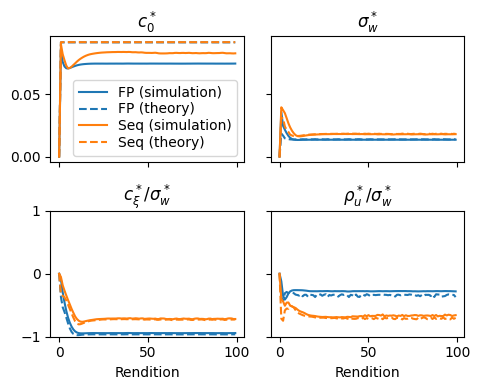

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex='all', sharey='row')

ti = int(tsyl_start[0,0]) # when to start

for k, (tr, l) in enumerate(zip((train_fp, train_lc), ('FP', 'Seq'))):
    c0_lhs, c0_rhs = [0], [0]
    sig_w_lhs, sig_w_rhs = [0], [0]
    corr_u_lhs, corr_u_rhs = [0], [0]
    corr_xi_lhs, corr_xi_rhs = [0], [0]
    for i, W in enumerate(tr[2][1:]):
        t_star = int(tsyl_end[0,i] - 5 - 1) # the last of tsyl_end is len so -1
        sig = tr[-1][t_star].std() # noise std at t*
        
        # c0: W mean
        rE_mean = tr[0][int(tsyl_start[0,0])-50:int(tsyl_start[0,0])].mean()
        d0 = np.sqrt(2 * np.pi) * sE * (1 - rE_mean) / rEmax
        c0_lhs.append(W.mean())
        c0_rhs.append((d0 - syl.mean()) / peak_rate + w_inh)

        # sig_w: W std
        sig_w_lhs.append(W.std())
        # sig_w_rhs.append(np.sqrt((sig / peak_rate)**2 + c_xi**2))
        sig_w_rhs.append(np.sqrt(sig**2 + syl.var()) / peak_rate)
    
        # corr between W(t*) and (normalized) xi
        corr_xi_lhs.append(correlation(syl[0], W.T)[0])
        corr_xi_rhs.append(-syl[0].std() / W.std() / peak_rate)
        
        # corr between W(t*) and epsilon(t*)
        corr_u_lhs.append(correlation(tr[-1][t_star], W[:,0], dim=1))
        corr_u_rhs.append((-sig / W.std() / peak_rate).mean())

    color, l1, l2 = 'C%d' % k, l + ' (simulation)', l + ' (theory)'
    ax[0,0].plot(c0_lhs, c=color, label=l1)
    ax[0,0].plot(c0_rhs, c=color, ls='--', label=l2)
    ax[0,1].plot(sig_w_lhs, c=color, label=l1)
    ax[0,1].plot(sig_w_rhs, c=color, ls='--', label=l2)
    ax[1,0].plot(corr_xi_lhs, c=color, label=l1)
    ax[1,0].plot(corr_xi_rhs, c=color, ls='--', label=l2)
    ax[1,1].plot(corr_u_lhs, c=color, label=l1)
    ax[1,1].plot(corr_u_rhs, c=color, ls='--', label=l2)
    
ax[1,0].set(ylim=[-1, 1], xlabel='Rendition', yticks=[-1, 0, 1])
ax[1,1].set(xlabel='Rendition')
ax[0,0].set_title(r'$c^*_0$')
ax[0,1].set_title(r'$\sigma^*_w$')
ax[1,0].set_title(r'$c^*_\xi / \sigma^*_w$')
ax[1,1].set_title(r'$\rho^*_u / \sigma^*_w$') 
ax[0,0].legend(labelspacing=0.2)
fig.tight_layout()

In [15]:
def perturb(net, Ws, axes, pert_vals, T_test=500, dt=1, disable_tqdm=False):
    '''
    Ws: list of weights
    axis: 1- or 2-tuple of axes of perturb, each must be NE-dimensional
    pert_vals: 1- or 2-tuple of perturbation values
    '''
    T_burn = T_test // 2

    rE = np.zeros((T_test, net.NE))
    rI = np.zeros((T_test, net.NI))
    rH = np.zeros((T_test, net.NH))
    aud = np.zeros((T_test, net.NE))
    rH[T_burn:,0] = peak_rate

    W_cur = net.W.copy() # backup W

    ret = np.zeros((len(Ws), len(pert_vals[0]), len(pert_vals[1]), 2))
    for i in range(len(Ws)):
        net.W = Ws[i] # update W

        for j in tqdm(range(len(pert_vals[0])), disable=disable_tqdm):
            for k in range(len(pert_vals[1])):
                aud[T_burn:] = axes[0] * pert_vals[0][j] + axes[1] * pert_vals[1][k]
                
                rE *= 0
                rI *= 0
                rE[0] = 1
                rI[0] = 5
        
                for t in range(1, T_test): # sim
                    aux = net.W @ rH[t-1] - net.w_inh * rH[t-1].sum()
                    recE = net.JEE @ rE[t-1] - net.JEI @ rI[t-1]
                    recI = net.JIE @ rE[t-1] - net.JII @ rI[t-1]
                    dE = -rE[t-1] + net.phiE(aux + aud[t-1] + recE)
                    dI = -rI[t-1] + net.phiI(recI + net.wI * rH[t-1].mean())
                    rE[t] = rE[t-1] + dE * dt / net.tauE
                    rI[t] = rI[t-1] + dI * dt / net.tauI
                ret[i,j,k] = rE[-100:].mean(), rI[-100:].mean()
    net.W = W_cur # restore
    
    return ret

In [16]:
def plot_3d_response(pert_vals, ret_, ylabel, zmax, 
                     levels=(1, 2, 3, 4), figsize=(8,3)):
    fig, ax = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=figsize, 
                           constrained_layout=True)
    ts_loc = 1 # or if the axis is normalized, np.linalg.norm(syl[0])
    ret = ret_.copy()
    ret[ret > zmax] = np.nan
    x, y = np.meshgrid(*pert_vals, indexing='ij') 
    for i, n in enumerate(('before', 'during', 'after')):
        ax[i].view_init(elev=12, azim=45, roll=0)
        ax[i].plot_surface(x, y, ret[i,...,0], cmap='plasma', alpha=0.8, 
                           antialiased=False)
        ax[i].contour(x, y, ret[i,...,0], zdir='z', levels=levels, offset=0, 
                      cmap='plasma', zorder=-1)
        ax[i].scatter(0, ts_loc, zs=0, marker='o', s=40, color='r', 
                      label='tutor song', alpha=0.8)
        ax[i].set(xticks=[], yticks=[], zticks=[], zlim=[0, zmax])
        ax[i].text(0, 0, zmax+1, n + ' learning', fontsize=11, ha='center')
        # Style setting 
        ax[i].set_box_aspect(aspect=None, zoom=0.85)
        ax[i].computed_zorder = False
        ax[i].grid(False)
        ax[i].xaxis.pane.fill = False
        ax[i].yaxis.pane.fill = False
        ax[i].zaxis.pane.fill = False
    ax[0].plot([0,x.max()], [ts_loc]*2, [0, 2.5], ls=':', c='r')
    ax[0].text(x.max(), ts_loc, 2.5, 'tutor song', 
               color='r', ha='center', va='bottom')
    ax[0].set(ylabel='song direction\n\n\n', xlabel=ylabel+'\n\n')
    fig.text(0.02, 0.4, 'population\nresponse', ha='center', rotation=90)
    return fig, ax

In [17]:
fp = train_fp[-1][T_burn-100:T_burn].mean(axis=0)
scale = np.linalg.norm(fp - fp.mean()) # used for scaling the random axes below

In [18]:
# the other axis is aligned with the intrinsic noise
axes = [fp, syl[0].copy()]
for i in range(2):
    axes[i] = (axes[i] - axes[i].mean()) #/ np.linalg.norm(axes[i])
pert_vals_intr = (np.linspace(-5, 5, num=11), np.linspace(-5, 5, num=11))
ret_intr = perturb(net_fp, [train_fp[2][i] for i in (0, 2, -1)], axes, pert_vals_intr)

100%|███████████████████████████████████████████| 11/11 [00:10<00:00,  1.09it/s]


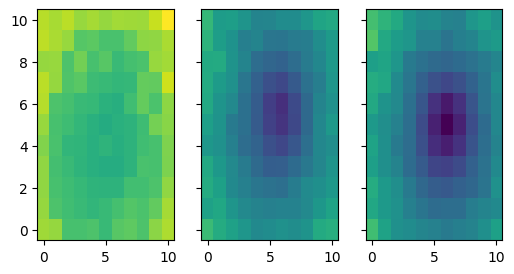

In [19]:
fig, ax = plt.subplots(1, ret_intr.shape[0], figsize=(6, 3), sharey='all', sharex='all')
for i in range(ret_intr.shape[0]):
    ax[i].imshow(ret_intr[i,...,0], aspect='auto', origin='lower', 
                 vmin=ret_intr[...,0].min(), vmax=ret_intr[...,0].max()) 

In [20]:
# the other axis is an arbitrary direction
axes = [rng.normal(0, scale, size=NE), syl[0].copy()]
for i in range(2):
    axes[i] = (axes[i] - axes[i].mean()) #/ np.linalg.norm(axes[i])
pert_vals_rand = (np.linspace(-0.5, 0.5, num=11), np.linspace(-5, 5, num=11))
ret_rand = perturb(net_fp, [train_fp[2][i] for i in (0, 2, -1)], axes, pert_vals_rand)

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.22it/s]


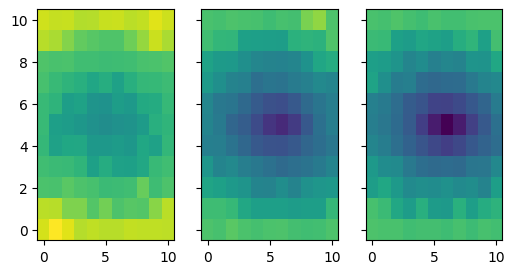

In [21]:
fig, ax = plt.subplots(1, ret_rand.shape[0], figsize=(6, 3), sharey='all', sharex='all')
for i in range(ret_rand.shape[0]):
    ax[i].imshow(ret_rand[i,...,0], aspect='auto', origin='lower', 
                 vmin=ret_rand[...,0].min(), vmax=ret_rand[...,0].max()) 

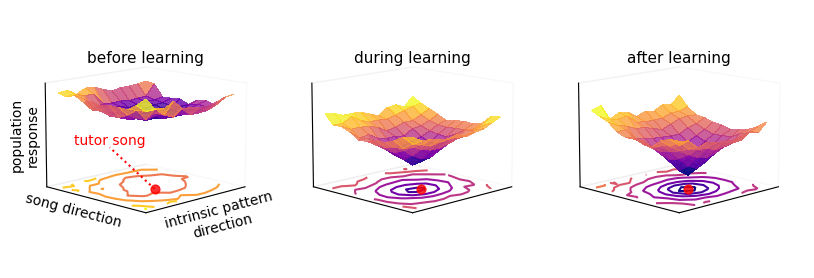

In [22]:
fig, ax = plot_3d_response(pert_vals_intr, ret_intr, 
                           ylabel='intrinsic pattern\ndirection', 
                           zmax=ret_intr[...,0].max(), 
                           levels=np.linspace(1, 5, num=10))

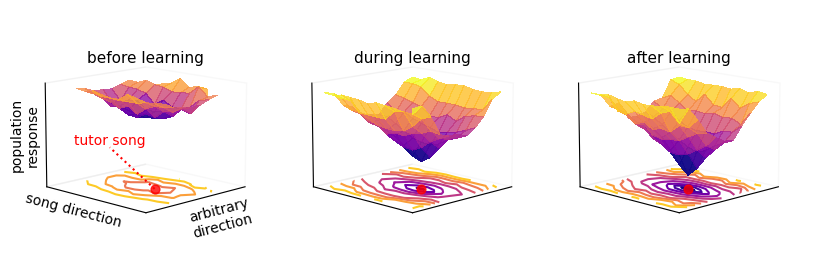

In [23]:
fig, ax = plot_3d_response(pert_vals_rand, ret_rand, 
                           ylabel='arbitrary\ndirection', 
                           zmax=ret_intr[...,0].max(),
                           levels=np.linspace(1, 5, num=10))

In [24]:
# def second_der(f, dx, axis=0):
#     fx = np.gradient(f, dx, axis=axis)
#     fxx = np.gradient(fx, dx, axis=axis)
#     return fxx
def curvature(f, dx, dy):
    fx = np.gradient(f, dx, axis=0)
    fy = np.gradient(f, dy, axis=1)
    fxx = np.gradient(fx, dx, axis=0)
    fyy = np.gradient(fy, dy, axis=1)
    fxy = np.gradient(fx, dy, axis=1)
    return (fxx * fyy - fxy**2) / (1 + fx**2 + fy**2)**2

In [25]:
# the other axis is an arbitrary direction
sens_offm = []
pert_vals_offm = (np.linspace(-0.1, 0.1, num=7), np.linspace(1-0.1, 1+0.1, num=7))
dx = pert_vals_offm[0][1] - pert_vals_offm[0][0]
dy = pert_vals_offm[1][1] - pert_vals_offm[1][0]
for _ in tqdm(range(30)):
    axes = [rng.normal(0, scale, size=NE), syl[0].copy()]
    for i in range(2):
        axes[i] = axes[i] - axes[i].mean()
    ret_offm = perturb(net_fp, [train_fp[2][-1]], axes, pert_vals_offm, disable_tqdm=True)
    sens_offm.append(np.abs(curvature(ret_offm[-1,...,0], dx, dy)).max())

100%|███████████████████████████████████████████| 30/30 [01:51<00:00,  3.71s/it]


In [26]:
# the other axis is aligned with the intrinsic noise
axes = [fp, syl[0].copy()]
for i in range(2):
    axes[i] = axes[i] - axes[i].mean()
pert_vals_onm = (np.linspace(-0.1, 0.1, num=7), np.linspace(1-0.1, 1+0.1, num=7))
dx = pert_vals_onm[0][1] - pert_vals_onm[0][0]
dx = pert_vals_onm[1][1] - pert_vals_onm[1][0]
ret_onm = perturb(net_fp, [train_fp[2][-1]], axes, pert_vals_onm)
sens_onm = np.abs(curvature(ret_onm[-1,...,0], dx, dy)).max()

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.62it/s]


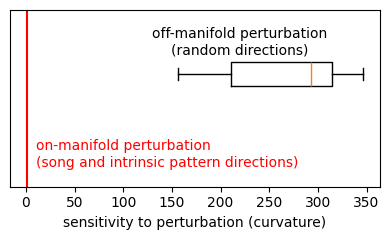

In [27]:
fig, ax = plt.subplots(1, figsize=(4, 2.5))

ax.boxplot(sens_offm, vert=False)
ax.text(220, 1.2, 'off-manifold perturbation\n(random directions)', ha='center', va='center')
ax.text(10, 0.5, 'on-manifold perturbation\n(song and intrinsic pattern directions)', 
        ha='left', va='center', color='r')
ax.axvline(sens_onm, color='r')
ax.set(xlabel='sensitivity to perturbation (curvature)', yticks=[], ylim=[0.3, 1.4])
fig.tight_layout()